In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [2]:
train_data = pd.read_csv("train_modeling.csv")
valid_data = pd.read_csv("valid_modeling.csv")
test_data = pd.read_csv("test_modeling.csv")

In [3]:
def convert_type(data):
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            data[c] = data[c].astype('category')
    return data

In [4]:
train_data = convert_type(train_data)
valid_data = convert_type(valid_data)
test_data = convert_type(test_data)

In [5]:
x_train = train_data.drop(["meter_reading",'Unnamed: 0'], axis=1)
y_train = train_data["meter_reading"].values
x_val = valid_data.drop(["meter_reading",'Unnamed: 0'], axis=1)
y_val = valid_data["meter_reading"].values
x_test = test_data.drop(["meter_reading",'Unnamed: 0'], axis=1)
y_test = test_data["meter_reading"].values

In [12]:
x_train.columns

Index(['month', 'day', 'hour', 'building_id', 'meter', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [13]:
gbm = lgb.LGBMRegressor(num_leaves=1000,
                        learning_rate=0.1,
                        n_estimators=100,
                        num_iteration=100,
                        verbose=0)

def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # 回帰問題
    'objective': 'regression',
    # RMSE (平均二乗誤差平方根) の最小化を目指す
    'metric': 'rmse',
    "num_leaves":1000,
    "learning_rate": 0.1,
    "num_iteration": 100,
    "n_estimators": 100,
    'verbose': 0
}

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train, valid_sets=[lgb_train, lgb_eval],categorical_feature=['building_id', 'meter', 'site_id','primary_use'])

'''
gbm.fit(x_train, y_train,
        eval_set=[(x_val, y_val)],
        eval_metric='rmsle')
'''

/Users/shun/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shun/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['building_id', 'meter', 'primary_use', 'site_id']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shun/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's rmse: 303.446	valid_1's rmse: 303.77
[2]	training's rmse: 273.988	valid_1's rmse: 274.291
[3]	training's rmse: 247.545	valid_1's rmse: 247.818
[4]	training's rmse: 223.824	valid_1's rmse: 224.079
[5]	training's rmse: 202.546	valid_1's rmse: 202.773
[6]	training's rmse: 183.472	valid_1's rmse: 183.685
[7]	training's rmse: 166.382	valid_1's rmse: 166.584
[8]	training's rmse: 151.07	valid_1's rmse: 151.258
[9]	training's rmse: 137.378	valid_1's rmse: 137.561
[10]	training's rmse: 125.156	valid_1's rmse: 125.328
[11]	training's rmse: 114.209	valid_1's rmse: 114.368
[12]	training's rmse: 104.464	valid_1's rmse: 104.624
[13]	training's rmse: 95.7966	valid_1's rmse: 95.9487
[14]	training's rmse: 88.092	valid_1's rmse: 88.2406
[15]	training's rmse: 81.2616	valid_1's rmse: 81.4092
[16]	training's rmse: 75.1892	valid_1's rmse: 75.3427
[17]	training's rmse: 69.839	valid_1's rmse: 69.9905
[18]	training's rmse: 65.1058	valid_1's rmse: 65.2604
[19]	training's rmse: 60.9249	valid_1's r

"\ngbm.fit(x_train, y_train,\n        eval_set=[(x_val, y_val)],\n        eval_metric='rmsle')\n"

In [14]:
y_pred = model.predict(x_test)

In [15]:
rmsle(y_test, y_pred)

/Users/shun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


('RMSLE', nan)

## 予測値と真値の分布を確認

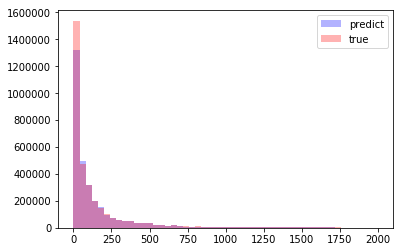

In [16]:
plt.hist(y_pred,bins=50, range=(0,2000), alpha=0.3 , color="b", label="predict")
plt.hist(y_test,bins=50, range=(0,2000), alpha=0.3 , color="r", label="true")
plt.legend()
plt.show()

## 予実プロットを確認

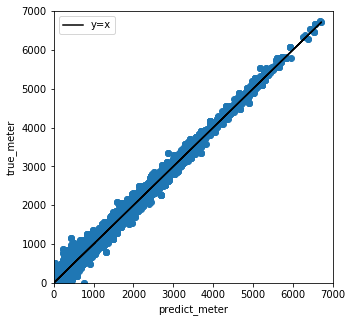

In [17]:
plt.figure(figsize=(5, 5)) 
plt.plot(y_pred, y_pred, label="y=x", color="black")
plt.scatter(y_pred, y_test)
plt.legend()
plt.xlim(0,7000)
plt.ylim(0,7000)
plt.xlabel("predict_meter")
plt.ylabel("true_meter")
plt.show()

In [18]:
importance = pd.DataFrame(model.feature_importance(), index=x_train.columns, columns=['importance'])\
                        .sort_values(ascending=False, by="importance")

In [19]:
importance

,importance
building_id,18833
day,16431
hour,12364
sea_level_pressure,9041
dew_temperature,7855
air_temperature,7784
square_feet,7235
month,5253
wind_direction,3836
meter,3258


In [27]:
submit_data = pd.read_csv("submit_test.csv")
submit_data_drop = submit_data.drop('Unnamed: 0', axis=1)
submit_data_drop = submit_data_drop.drop('row_id', axis=1)

In [4]:
sample_submit = pd.read_csv("sample_submission.csv")

In [5]:
sample_submit.nunique()

row_id           41697600
meter_reading           1
dtype: int64

In [28]:
#df.loc[df['A'] < 0, 'A'] = -100
submit_data_drop.loc[submit_data_drop["primary_use"]=="Services", "primary_use"]="Public services"

In [29]:
set(list(submit_data_drop["primary_use"].unique()))-set(list(x_train["primary_use"].unique()))

set()

In [30]:
y_pred_submit = model.predict(submit_data_drop)

ValueError: train and valid dataset categorical_feature do not match.

ラベルのユニーク数が一致してないといけないのは、「buildeing_id, meter, site_id」の3つ

In [31]:
x_train.nunique()

month                  12
day                    31
hour                   24
building_id           743
meter                   3
site_id                 6
primary_use            15
square_feet           705
year_built            110
floor_count            15
air_temperature       264
cloud_coverage          6
dew_temperature       230
precip_depth_1_hr      37
sea_level_pressure    389
wind_direction         37
wind_speed             32
dtype: int64

In [32]:
submit_data_drop.nunique()

month                  12
day                    31
hour                   24
building_id           793
meter                   4
site_id                11
primary_use            15
square_feet           783
year_built             74
floor_count            12
air_temperature       497
cloud_coverage         10
dew_temperature       461
precip_depth_1_hr      86
sea_level_pressure    544
wind_direction         38
wind_speed             43
dtype: int64